cvt_census.ipynb

Discussion: Compute Florida congressional districts using census data.

Licensing: This code is distributed under the GNU LGPL license.
    
Modified: 14 November 2016

Author: John Burkardt, Lukas Bystricky

In [1]:
# Import necessary libraries and set plot option
%matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.spatial as spatial

Using matplotlib backend: agg


# 27 Florida Congressional Districts from Census Data #

Legally, Florida must be divided up into 27 congressional districts of roughly equal population.  This process can be manipulated to favor a particular party or candidate.  It is interesting to investigate the shape of districts that might be computed by an approach inspired by CVT's. 

We will look at:
* how to read a file containing usable census data;
* how to set up the PDF and CDF data from the census data;
* how to use the CDF data to randomly select a single person at random in Florida;
* how to sample N persons from Florida, with their latitudes and longitudes;
* how to initialize each congressional district's "generator" point;
* how to compute the nearest generator point to each selected person;
* how to carry out a CVT iteration that, on each step, selects N random persons, assigns them to nearest generator, and replaces generator by centroid.

# A Census Data File#

The file "florida_census.txt" is available from the web page 
http://people.sc.fsu.edu/~jburkardt/classes/urop_2016/florida_census.txt

For 4,245 locations in Florida, the US Census Bureau recorded an identifying
ID number (which we will ignore), the population, the longitude and latitude.

Note that this file is not the original data from the Census Bureau website.
Many piece of information were removed to reduce the file size and simplify
the processing step.  Also, a number of legitimate locations (especially in
Key West!) fall outside the polygon that we use to represent the shape of Florida.
In order to avoid some confusing results, we set the populations of those
sites to zero!

Now we need to read this file and make its data available to our Python codes.

In [8]:
# Code to read the census data file.

def florida_census_read ( ):

  import numpy as np

  input = open ( 'florida_census.txt', 'r' )

  m = 4245
  cen_pop = np.zeros ( m, dtype = np.int32 )
  cen_lon = np.zeros ( m, dtype = np.float64 )
  cen_lat = np.zeros ( m, dtype = np.float64 )

  i = 0
  for line in input:

    data = line.split ( )
    id = data[0]
    cen_pop[i] = data[1]
    cen_lon[i] = data[2]
    cen_lat[i] = data[3]
    i = i + 1

  input.close ( )

  return cen_pop, cen_lon, cen_lat
#
#  Test the function.
#
cen_pop, cen_lon, cen_lat = florida_census_read ( )
m = len ( cen_pop )

print ( '' )
print ( '    I     Pop       Lon       Lat' )
print ( '' )
for i in range ( 0, 10 ):
  print ( '  %3d  %6d  %8.4f  %8.4f' % ( i, cen_pop[i], cen_lon[i], cen_lat[i] ) ) 
print ( '...')
for i in range ( m - 10, m ):
  print ( '  %3d  %6d  %8.4f  %8.4f' % ( i, cen_pop[i], cen_lon[i], cen_lat[i] ) ) 


    I     Pop       Lon       Lat

    0    7431  -82.3334   29.6511
    1    3308  -82.3314   29.6680
    2    2770  -82.3301   29.6842
    3    5665  -82.3081   29.6795
    4    4976  -82.3169   29.6568
    5    4350  -82.2885   29.6558
    6    6075  -82.2902   29.6317
    7    2180  -82.3322   29.6390
    8    3630  -82.3335   29.6274
    9    1364  -82.3493   29.6305
...
  4235    2506  -86.0550   30.3097
  4236    7367  -86.3621   30.3869
  4237       0  -86.1947   30.3021
  4238    1651  -85.5683   30.7151
  4239    3335  -85.5911   30.7873
  4240    3228  -85.4889   30.7741
  4241    3624  -85.7855   30.6721
  4242    2282  -85.5749   30.5019
  4243    6615  -85.7626   30.5286
  4244    4161  -85.5266   30.6417


# Polygon contains point? #

In the polygon notebook, we showed that we used triangulation
to determine if a polygon contained a point.  When dealing with
Florida, we will prefer another method, which is made available to
you in a Python file:
    
http://people.sc.fsu.edu/~jburkardt/classes/urop_2016/polygon_contains_point.py
    
You should copy this and put it in the same directory as your notebook,
and invoke it using the command

    from polygon_contains_point import polygon_contains_point
    
The function has the form
```python
def polygon_contains_point ( x, y, px, py ):
  ***
  return inside
```
where the point is (x,y), the coordinates of the vertices of the 
polygon are in the arrays px and py, and the result "inside" is 
True if the polygon contains the point.

Test this function using the florida longitude and latitude data
for the polygon coordinates px and py, and the following points:
    
    Point  Lon     Lat  Where?
      0    -87     26   (In the ocean!)
      1    -81     30   (In the ocean!)
      2    -84     30.5 (Near Tallahassee
      3    -81     26   (Near Miami)

In [3]:
# Test code for polygon contains point #

from polygon_contains_point import polygon_contains_point

x = np.array ( [ -87.0, -81.0, -84.0, -81.0 ] )
y = np.array ( [  26.0,  30.0,  30.5,  26.0 ] )

for i in range ( 0, 4 ):
  inside = polygon_contains_point ( x[i], y[i], lon, lat )
  print ( '  %2d  %8.4f  %8.4f  %s' % ( i, x[i], y[i], inside ) )

   0  -87.0000   26.0000  False
   1  -81.0000   30.0000  False
   2  -84.0000   30.5000  True
   3  -81.0000   26.0000  True


# Acceptance/Rejection Sampling of the Florida Polygon #

In the polygon notebook, we showed that we could use triangulation
to sample the polygon uniformly.  But because Florida is a complicated
polygon, we will try a simpler method. 

To get a uniformly random point from Florida:
* Surround Florida by a rectangular box;
* Get a random point in that box (easy);
* If the Florida polygon does not contain that point, go back one step;

A box that contains Florida has the lower left corner (-88,25) and
the upper right corner (-80,31).

To get a sample point, then, we get unit random numbers r1 and r2 and 
compute:

    x = -88 + 8 * r1
    y =  25 + 6 * r2

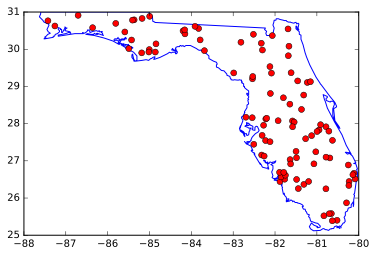

In [4]:
# Code for acceptance/rejection sampling of the Florida Polygon

def florida_sample ( m ):
  xy = np.zeros ( [ m, 2 ] )
  i = 0
  while ( i < m ):
    r1 = np.random.rand ( )
    r2 = np.random.rand ( )
    x = -88.0 + 8.0 * r1
    y =  25.0 + 6.0 * r2
    inside = polygon_contains_point ( x, y, lon, lat )
    if ( inside ):
      xy[i,0] = x
      xy[i,1] = y
      i = i + 1
  return xy
#
#  Test the code.
#
m = 100
xy = florida_sample ( m )
plt.plot ( lon, lat, 'b-' )
plt.plot ( xy[:,0], xy[:,1], 'ro' )

# CVT step for Florida #

Now we can write the CVT step for Florida.

Given N current generators G, and using M sample points, we want to
estimate the N centroids C of the corresponding Voronoi regions.

Use the following seven Florida cities for G:

    -87.20, 30.43  Pensacola
    -84.25, 30.46  Tallahassee
    -81.66, 30.34  Jacksonville
    -82.48, 27.97  Tampa
    -82.32, 29.65  Gainesville
    -81.30, 28.42  Orlando
    -80.21, 25.78  Miami

In [5]:
#  cvt_step_florida()
#
def cvt_step_florida ( g, m ):
  import numpy as np
  n = g.shape[0]
  s = florida_sample ( m )
  ni = np.zeros ( n )
  c = np.zeros ( [ n, 2 ])
  for i in range ( 0, m ):
    k = -1
    d = np.Inf
    for j in range ( 0, n ):
      dj = np.linalg.norm ( s[i,:] - g[j,:] )
      if ( dj < d ):
        d = dj
        k = j
    ni[k] = ni[k] + 1
    c[k,:] = c[k,:] + s[i,:]
    
  for i in range ( 0, n ):
    c[i,:] = c[i,:] / float ( ni[i] )
    
  return c
#
#  Test the function using 7 Florida cities to start with.
#
import numpy as np
g = np.array ( [ \
  [ -87.20, 30.43 ], \
  [ -84.25, 30.46 ], \
  [ -81.66, 30.34 ], \
  [ -82.48, 27.97 ], \
  [ -82.32, 29.65 ], \
  [ -81.30, 28.42 ], \
  [ -80.21, 25.78 ] ] )

m = 1000
c = cvt_step_florida ( g, m )
print ( c )

[[-86.61426552  30.71168878]
 [-84.54031681  30.32754013]
 [-81.70440116  30.21489764]
 [-82.12693031  27.66841477]
 [-82.50193766  29.61688588]
 [-81.17685053  28.12548008]
 [-80.83812526  26.16262678]]


# CVT Iteration for Florida #

Once we have a CVT step function, the CVT iteration is easy.  Try taking 10 steps,
and plot the locations of G before the iteration, and then at the end.

You may also be able to plot the Voronoi diagram on top of the plot of the cities.

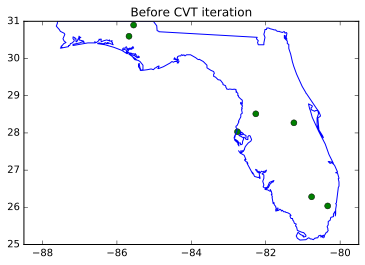

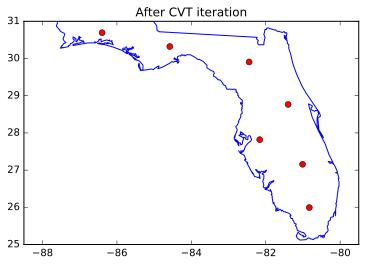

In [8]:
# Code for CVT Iteration for Florida
#
def cvt_florida ( n, m, step_num ):

  g = florida_sample ( n )

# vor = spatial.Voronoi ( g )
# spatial.voronoi_plot_2d ( vor )
  plt.plot ( g[:,0], g[:,1], 'go' )
  plt.plot ( lon, lat, 'b-' )
  plt.axis ( 'Equal' )
  plt.title ( 'Before CVT iteration')
  plt.show ( )

  for step in range ( 0, step_num ):
    c = cvt_step_florida ( g, m )
    g = c.copy ( )
  return g
#
#  Test the code.
#
n = 7
m = 5000
step_num = 10
g = cvt_florida ( n, m, step_num )

#vor = spatial.Voronoi ( g )
#spatial.voronoi_plot_2d ( vor )
plt.plot ( g[:,0], g[:,1], 'ro' )
plt.plot ( lon, lat, 'b-' )
plt.axis ( 'Equal' )
plt.title ( 'After CVT iteration')
plt.show ( )